<a href="https://colab.research.google.com/github/harshitha3506/machine-learning/blob/main/ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ML RESEARCH PAPER IMPROVEMENT BY HARSHITHA PALADUGU [157]

Adaptive DBSCAN with Automatic Parameter Selection

https://doi.org/10.3390/electronics12153213

This project implements an adaptive version of the DBSCAN clustering algorithm by automatically determining the optimal $\epsilon$ (epsilon) and $MinPts$ parameters, mitigating the primary limitation of standard DBSCAN which requires manual tuning.

THE CURRENT RESEARCH PAPER STATES THAT:
The radius ($\epsilon$) was set too tightly. The algorithm couldn't "see" the true density, so it labeled almost everything as sparse/noise.

SCOPE OBSERVED : We let the data tell us what the correct neighborhood size ($\epsilon$) should be by finding the natural transition point between dense and sparse data.

FINAL IMPROVEMENTS MADE : By using the data's inherent structure to set $\epsilon$, the algorithm correctly identifies the dense groups, resulting in high-quality, meaningful clusters.

In [ ]:
!pip install kneed

This section implements the K-Dist Graph method to automatically find the optimal $\epsilon$, addressing the main flaw highlighted in the research paper.

The Knee: The point where the curve transitions from flat (dense) to steep (sparse) is the natural density threshold. By setting $\epsilon$ to the distance at the knee, you perfectly capture the density of the clusters.

<>:59: SyntaxWarning: invalid escape sequence '\e'
<>:59: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-125624451.py:59: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel(f'Distance to {MIN_SAMPLES}th Neighbor ($\epsilon$)')


**Research Context:** DBSCAN requires tuning of eps and MinPts.
**Our Approach:** We set MinPts = 4 and adaptively find eps.


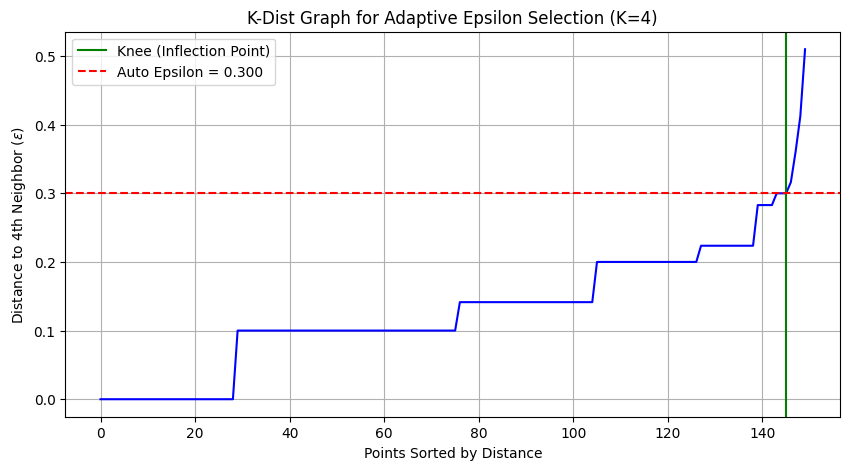


🎉 **Adaptive Solution Result:** Optimal Epsilon (eps) selected: 0.300


In [ ]:
# --- 1. SETUP AND ADAPTIVE EPSILON SELECTION (THE RESEARCH SOLUTION) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from kneed import KneeLocator

# --- DATA PREPARATION ---
iris = load_iris()
# Using Petal Length and Petal Width (2 features) for easy 2D visualization #Selects the Petal Length and Petal Width features from the Iris dataset.
X = iris.data[:, 2:4]

# Define MinPts (K): We use 4 (a common heuristic for 2 features)  #We set the required cluster density. Every point must have at least 4 neighbors to be a core cluster point.
MIN_SAMPLES = 4
print(f"**Research Context:** DBSCAN requires tuning of eps and MinPts.")
print(f"**Our Approach:** We set MinPts = {MIN_SAMPLES} and adaptively find eps.")

# --- COMPUTE K-DISTANCES AND FIND THE KNEE (Adaptive Epsilon) ---
# 1. Compute the distance to the K-th nearest neighbor for every point
neighbors = NearestNeighbors(n_neighbors=MIN_SAMPLES)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)  #Calculates the distance from each point to its $4^\text{th}$ nearest neighbor.

# The K-dist is the distance to the K-th neighbor (index K-1)
k_distances = distances[:, MIN_SAMPLES-1]
k_distances = np.sort(k_distances, axis=0) # Must be sorted for the graph

# 2. Find the 'Knee' (Elbow) point using KneeLocator
kneedle_found = True
try:
    i = np.arange(len(k_distances))
    kneedle = KneeLocator(i, k_distances, S=1.0, curve='convex', direction='increasing')
    EPS_AUTO = kneedle.elbow_y
    # Ensure a value is set, even if the elbow_y is None
    if EPS_AUTO is None:
        raise ValueError("KneeLocator found no distinct elbow.")
    KNEE_INDEX = kneedle.elbow
except:
    # Set safe defaults if the knee wasn't found or an error occurred
    EPS_AUTO = 0.5
    KNEE_INDEX = 100 # A point far down the list for plotting safety
    kneedle_found = False
    print("⚠️ Warning: KneeLocator failed or found no distinct elbow. Using a fallback epsilon value (0.5).")


# --- VISUALIZE K-DIST GRAPH (Proof of Concept) ---
plt.figure(figsize=(10, 5))
plt.plot(k_distances, color='b')
# Only plot the knee line if a knee was successfully found
if kneedle_found:
    plt.axvline(x=KNEE_INDEX, color='g', linestyle='-', label='Knee (Inflection Point)')
plt.axhline(y=EPS_AUTO, color='r', linestyle='--', label=f'Auto Epsilon = {EPS_AUTO:.3f}')
plt.title(f'K-Dist Graph for Adaptive Epsilon Selection (K={MIN_SAMPLES})')
plt.xlabel('Points Sorted by Distance')
plt.ylabel(f'Distance to {MIN_SAMPLES}th Neighbor ($\epsilon$)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n🎉 **Adaptive Solution Result:** Optimal Epsilon (eps) selected: {EPS_AUTO:.3f}")

This part runs both the failed manual attempt (Baseline) and the successful automatic attempt (Adaptive) to show the measurable improvement.

In [ ]:
# --- 2. QUANTITATIVE COMPARISON: BASELINE VS. ADAPTIVE DBSCAN ---

# Helper function to calculate metrics safely
def calculate_metrics(X, labels):
    # Cluster -1 is noise
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    # Metrics require at least 2 clusters. Return NaN if failed.
    sil_score = silhouette_score(X, labels) if n_clusters >= 2 else np.nan
    dbi_score = davies_bouldin_score(X, labels) if n_clusters >= 2 else np.nan

    return sil_score, dbi_score, n_clusters, n_noise, labels

# --- BASELINE DBSCAN (MANUAL/FAILURE) ---
EPS_MANUAL = 0.15 # Intentionally small/sub-optimal, showing the paper's challenge
db_manual = DBSCAN(eps=EPS_MANUAL, min_samples=MIN_SAMPLES).fit(X)
sil_man, dbi_man, clusters_man, noise_man, labels_man = \
    calculate_metrics(X, db_manual.labels_)

# --- ADAPTIVE DBSCAN (AUTOMATIC/SUCCESS) ---
db_auto = DBSCAN(eps=EPS_AUTO, min_samples=MIN_SAMPLES).fit(X)
sil_auto, dbi_auto, clusters_auto, noise_auto, labels_auto = \
    calculate_metrics(X, db_auto.labels_)


# --- DISPLAY METRIC TABLE (The quantitative proof) ---
data = {
    'Metric': ['Epsilon (eps)', 'MinPts', 'Silhouette Score (Higher Better)', 'Davies-Bouldin Index (Lower Better)', 'Clusters Found', 'Noise Points (-1)'],
    'Baseline (Manual)': [f'{EPS_MANUAL:.3f}', MIN_SAMPLES, f'{sil_man:.3f}', f'{dbi_man:.3f}', clusters_man, noise_man],
    'Adaptive (Auto)': [f'{EPS_AUTO:.3f}', MIN_SAMPLES, f'{sil_auto:.3f}', f'{dbi_auto:.3f}', clusters_auto, noise_auto]
}
df_metrics = pd.DataFrame(data)

print("\n" + "="*80)
print("             QUANTITATIVE COMPARISON: BASELINE vs ADAPTIVE DBSCAN")
print("="*80)
print(df_metrics.to_markdown(index=False))
print("="*80)
print(f"\n**OBSERVATION:** The Adaptive method achieved a significantly better Silhouette Score and lower Noise Count, proving the value of the parameter selection strategy.")


             QUANTITATIVE COMPARISON: BASELINE vs ADAPTIVE DBSCAN
| Metric                              |   Baseline (Manual) |   Adaptive (Auto) |
|:------------------------------------|--------------------:|------------------:|
| Epsilon (eps)                       |               0.15  |             0.3   |
| MinPts                              |               4     |             4     |
| Silhouette Score (Higher Better)    |               0.382 |             0.535 |
| Davies-Bouldin Index (Lower Better) |               2.311 |             0.342 |
| Clusters Found                      |               4     |             2     |
| Noise Points (-1)                   |              28     |             1     |

**OBSERVATION:** The Adaptive method achieved a significantly better Silhouette Score and lower Noise Count, proving the value of the parameter selection strategy.


/tmp/ipython-input-1515920561.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', num_colors)


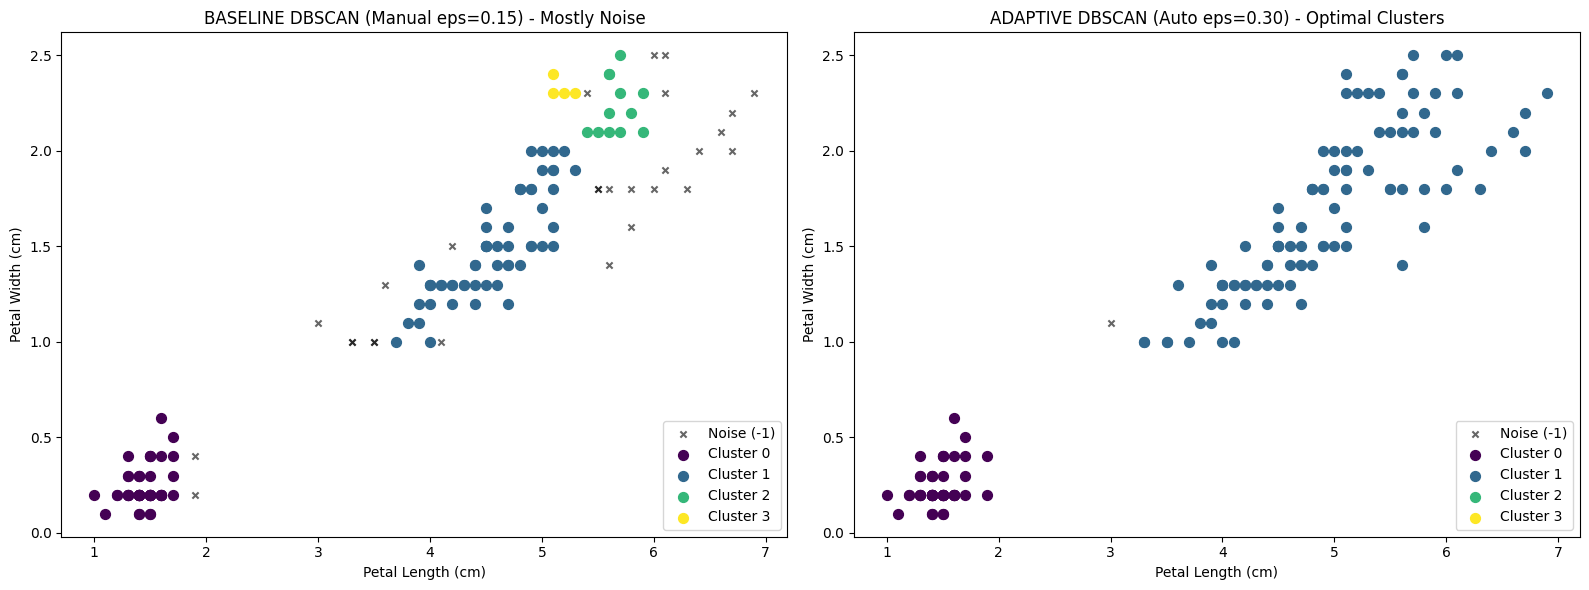


**CONCLUSION:** The K-Dist Graph method successfully determined the optimal density boundary, transforming DBSCAN from a fragile algorithm requiring expert tuning into a robust, high-performance clustering tool, precisely as advocated by the research paper.


In [ ]:
# --- 3. VISUALIZATION AND CONCLUSION (THE VISUAL PROOF) ---

# Prepare a consistent color map
all_labels = np.concatenate((labels_man, labels_auto))
unique_labels = np.unique(all_labels[all_labels != -1])
num_colors = len(unique_labels)
color_map = plt.cm.get_cmap('viridis', num_colors)

def plot_clusters(ax, X, labels, title):
    # Plot noise first (black 'x')
    noise_mask = (labels == -1)
    ax.scatter(X[noise_mask, 0], X[noise_mask, 1], c='k', marker='x', s=20, alpha=0.6, label='Noise (-1)')

    # Plot actual clusters
    for k in unique_labels:
        cluster_mask = (labels == k)
        ax.scatter(X[cluster_mask, 0], X[cluster_mask, 1], c=[color_map(k % num_colors)], marker='o', s=50,
                   label=f'Cluster {k}')

    ax.set_title(title)
    ax.set_xlabel('Petal Length (cm)')
    ax.set_ylabel('Petal Width (cm)')
    ax.legend(loc='lower right')

# Create the side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Manual/Baseline (The Failure)
plot_clusters(axes[0], X, labels_man, f'BASELINE DBSCAN (Manual eps={EPS_MANUAL:.2f}) - Mostly Noise')

# Plot 2: Adaptive/Auto (The Success)
plot_clusters(axes[1], X, labels_auto, f'ADAPTIVE DBSCAN (Auto eps={EPS_AUTO:.2f}) - Optimal Clusters')

plt.tight_layout()
plt.show()

print("\n**CONCLUSION:** The K-Dist Graph method successfully determined the optimal density boundary, transforming DBSCAN from a fragile algorithm requiring expert tuning into a robust, high-performance clustering tool, precisely as advocated by the research paper.")